# Notebook 13: Explainable AI (XAI) with SHAP

## Addressing Key Research Gap: Lack of Model Interpretability in Agriculture ML

# 1. Import Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

shap.initjs()
print(f"✅ Libraries loaded. SHAP version: {shap.__version__}")

✅ Libraries loaded. SHAP version: 0.50.0


In [20]:
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# 2. Load Data and Models

In [21]:
X_test = np.load("../data/processed/ml_ready/X_test_scaled.npy")
y_test = np.load("../data/processed/ml_ready/y_test.npy")
print(f"📊 Test samples: {X_test.shape[0]}, Features: {X_test.shape[1]}")

📊 Test samples: 440, Features: 39


In [22]:
with open("../data/processed/ml_ready/feature_names.pkl", "rb") as f:
    feature_names = list(pickle.load(f))

with open("../models/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)
crop_names = list(label_encoder.classes_)

n_features = len(feature_names)
n_classes = len(crop_names)
print(f"📋 Features: {n_features}, Crops: {n_classes}")

📋 Features: 39, Crops: 22


In [23]:
with open('../models/random_forest_model.pkl', 'rb') as f:
    model = pickle.load(f)
print(f"✅ Model loaded: {type(model).__name__}")

✅ Model loaded: RandomForestClassifier


# 3. Create SHAP Explainer

In [24]:
print("🔧 Creating SHAP TreeExplainer...")
explainer = shap.TreeExplainer(model)
print("✅ Explainer created!")

🔧 Creating SHAP TreeExplainer...
✅ Explainer created!


In [25]:
# Sample 100 test instances
SAMPLE_SIZE = 100
rng = np.random.default_rng(42)
sample_indices = rng.choice(len(X_test), size=min(SAMPLE_SIZE, len(X_test)), replace=False)
X_sample = X_test[sample_indices]
y_sample = y_test[sample_indices]

print(f"📊 Calculating SHAP values for {len(X_sample)} samples...")
shap_values_raw = explainer.shap_values(X_sample)

# Debug structure
print(f"\n📋 SHAP values structure:")
print(f"   Type: {type(shap_values_raw)}")
if isinstance(shap_values_raw, list):
    print(f"   List length: {len(shap_values_raw)}")
    print(f"   Element shape: {shap_values_raw[0].shape}")
    # Format: list of (n_samples, n_features) arrays, one per class
    shap_values = shap_values_raw  # Keep as list
else:
    print(f"   Array shape: {shap_values_raw.shape}")
    # Format: (n_samples, n_features, n_classes) or similar
    if shap_values_raw.ndim == 3:
        # Convert to list format: list of (n_samples, n_features)
        if shap_values_raw.shape[2] == n_classes:
            # Shape is (samples, features, classes)
            shap_values = [shap_values_raw[:, :, i] for i in range(n_classes)]
        elif shap_values_raw.shape[0] == n_classes:
            # Shape is (classes, samples, features)
            shap_values = [shap_values_raw[i] for i in range(n_classes)]
        else:
            shap_values = shap_values_raw
    else:
        shap_values = shap_values_raw

print(f"\n✅ Converted to list format:")
print(f"   Classes: {len(shap_values)}, Shape per class: {shap_values[0].shape}")

📊 Calculating SHAP values for 100 samples...

📋 SHAP values structure:
   Type: <class 'numpy.ndarray'>
   Array shape: (100, 39, 22)

✅ Converted to list format:
   Classes: 22, Shape per class: (100, 39)


# 4. Global Feature Importance

In [26]:
# Stack all class arrays: shape (n_classes, n_samples, n_features)
shap_stacked = np.stack(shap_values, axis=0)
print(f"Stacked shape: {shap_stacked.shape}")

# Mean absolute SHAP per feature (across classes and samples)
# axis 0 = classes, axis 1 = samples -> result is (n_features,)
global_importance = np.mean(np.abs(shap_stacked), axis=(0, 1))
print(f"Global importance shape: {global_importance.shape}")
print(f"Feature names length: {len(feature_names)}")

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP|': global_importance
}).sort_values('Mean |SHAP|', ascending=False)

print("\n📊 Top 10 Most Important Features:")
print(feature_importance_df.head(10).to_string(index=False))

Stacked shape: (22, 100, 39)
Global importance shape: (39,)
Feature names length: 39

📊 Top 10 Most Important Features:
                 Feature  Mean |SHAP|
                humidity     0.013721
                       K     0.012187
                       N     0.010757
                rainfall     0.010234
                       P     0.008595
        K_ph_interaction     0.007271
                 NPK_sum     0.006939
humidity_category_Medium     0.006913
       rainfall_per_temp     0.006559
      water_availability     0.006407


Bar Plot

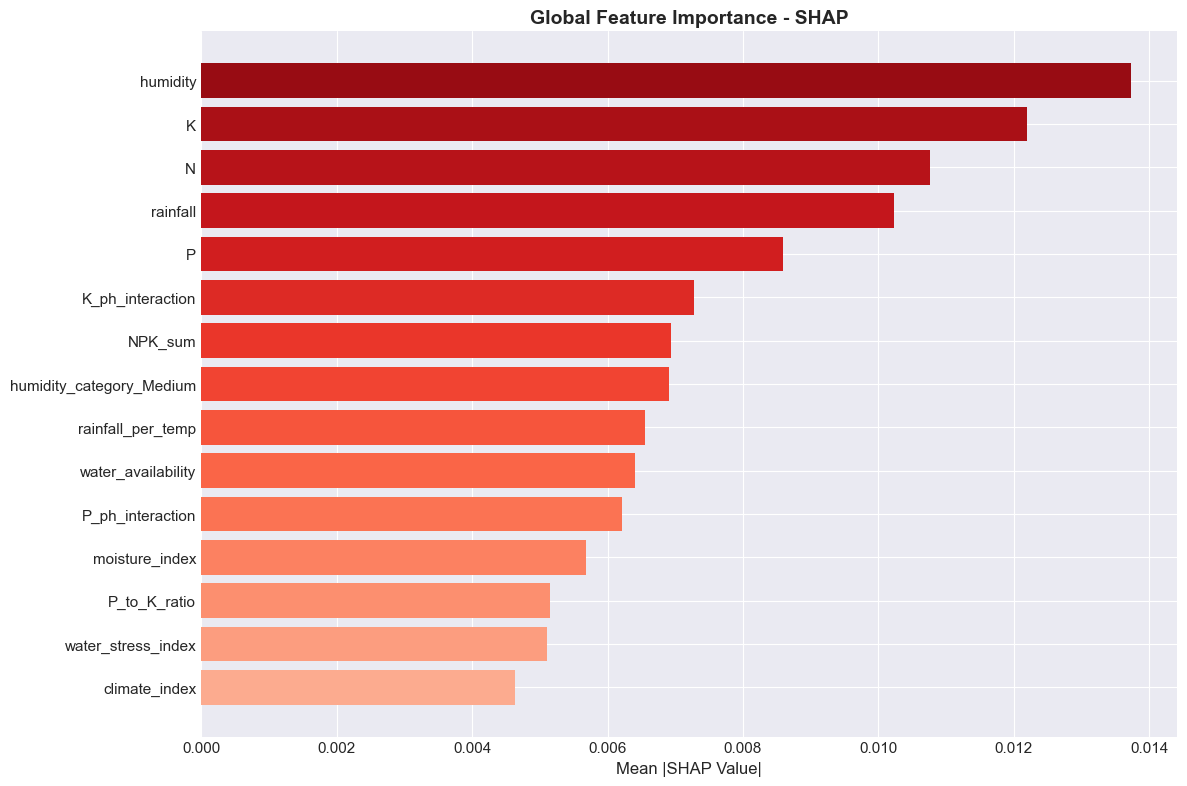

Saved: 50_shap_global_importance.png


In [43]:
plt.figure(figsize=(12, 8))
top_n = 15
top_features = feature_importance_df.head(top_n).sort_values('Mean |SHAP|', ascending=True)
colors = plt.cm.Reds(np.linspace(0.3, 0.9, top_n))
plt.barh(top_features['Feature'], top_features['Mean |SHAP|'], color=colors)
plt.xlabel('Mean |SHAP Value|')
plt.title('Global Feature Importance - SHAP', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/visualizations/50_shap_global_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: 50_shap_global_importance.png")

# 5. SHAP Summary Plots

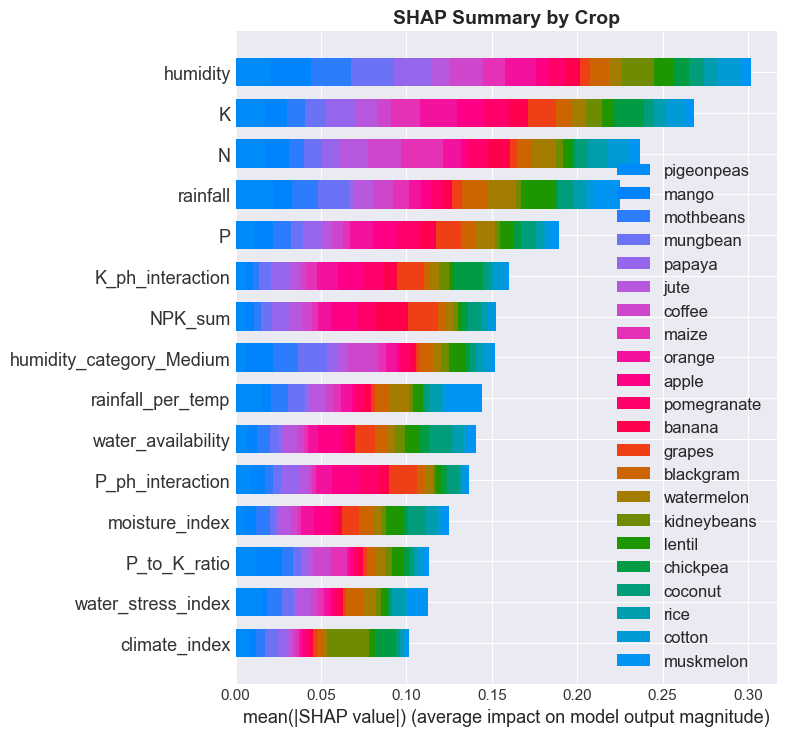

Saved: 51_shap_summary_bar.png


In [45]:
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names,
                  plot_type='bar', max_display=15, class_names=crop_names, show=False)
plt.title('SHAP Summary by Crop', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/visualizations/51_shap_summary_bar.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: 51_shap_summary_bar.png")

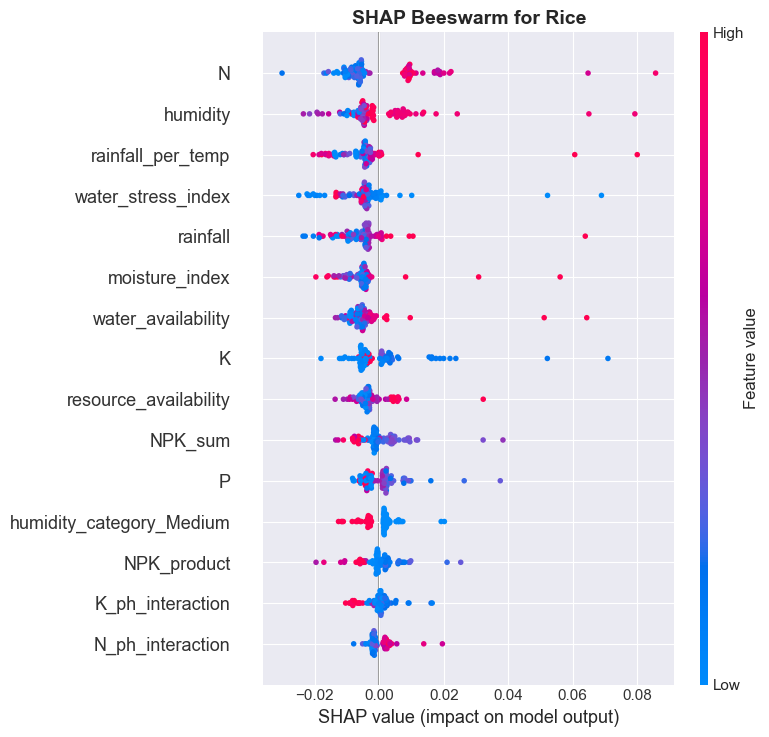

Saved: 51_shap_beeswarm_rice.png


In [46]:
# Beeswarm for single class (rice)
target_crop = 'rice'
crop_idx = crop_names.index(target_crop) if target_crop in crop_names else 0

plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values[crop_idx], X_sample, feature_names=feature_names, max_display=15, show=False)
plt.title(f'SHAP Beeswarm for {crop_names[crop_idx].title()}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/visualizations/51_shap_beeswarm_rice.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: 51_shap_beeswarm_rice.png")

# 6. Single Prediction Explanation (Waterfall)

In [ ]:
sample_idx = 0
predicted_class = model.predict(X_sample[sample_idx:sample_idx+1])[0]
true_class = y_sample[sample_idx]

📋 Sample 0:
   True: coffee, Predicted: coffee
   Correct: ✅


In [47]:
print(f"Sample {sample_idx}:")
print(f"True: {crop_names[true_class]}, Predicted: {crop_names[predicted_class]}")
print(f"Correct: {'OK' if predicted_class == true_class else 'NO'}")

Sample 0:
True: coffee, Predicted: coffee
Correct: OK


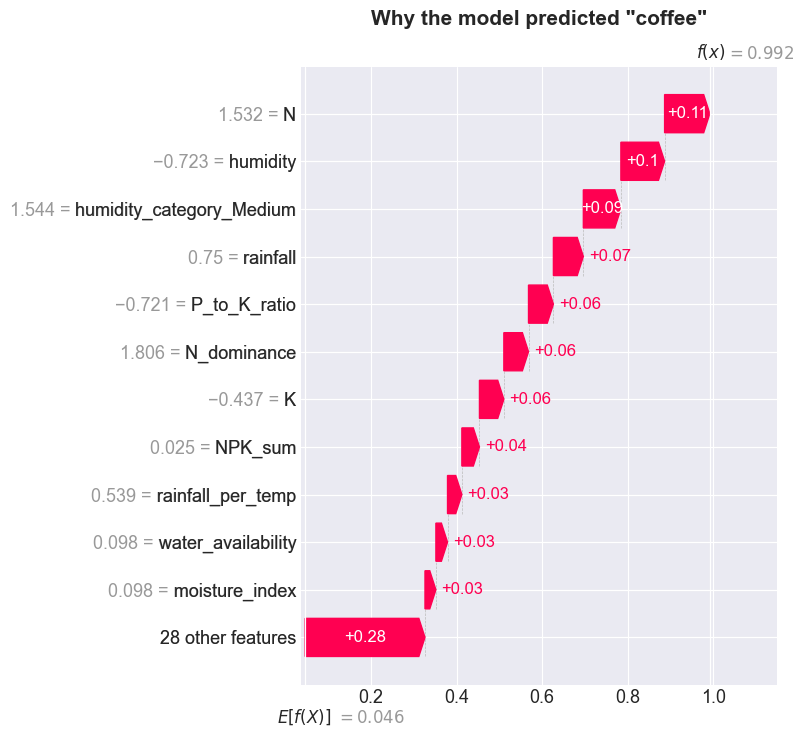

Saved: 52_shap_waterfall.png


In [54]:
# SHAP Waterfall plot (NumPy-safe)

plt.figure(figsize=(11, 8))

explanation = shap.Explanation(
    values=shap_values[predicted_class][sample_idx],
    base_values=explainer.expected_value[predicted_class],
    data=X_sample[sample_idx],       
    feature_names=feature_names
)
shap.plots.waterfall(explanation,max_display=12,show=False)

plt.title(f'Why the model predicted "{crop_names[predicted_class]}"',fontsize=15,fontweight='bold',pad=12)
plt.tight_layout()

plt.savefig("../data/visualizations/52_shap_waterfall.png",dpi=150,bbox_inches="tight")
plt.show()
print("Saved: 52_shap_waterfall.png")


In [57]:
print("FARMER-FRIENDLY EXPLANATION")
print(f"Recommendation: Plant {crop_names[predicted_class].upper()}")
print("Top Reasons:")
contributions = sorted(zip(feature_names, shap_values[predicted_class][sample_idx]), 
                       key=lambda x: abs(x[1]), reverse=True)
for i, (feat, val) in enumerate(contributions[:5], 1):
    direction = "supports" if val > 0 else "opposes"
    print(f"  {i}. {feat}: {direction} ({val:+.4f})")

FARMER-FRIENDLY EXPLANATION
Recommendation: Plant COFFEE
Top Reasons:
  1. N: supports (+0.1057)
  2. humidity: supports (+0.1022)
  3. humidity_category_Medium: supports (+0.0877)
  4. rainfall: supports (+0.0700)
  5. P_to_K_ratio: supports (+0.0581)


# 7. Force Plot

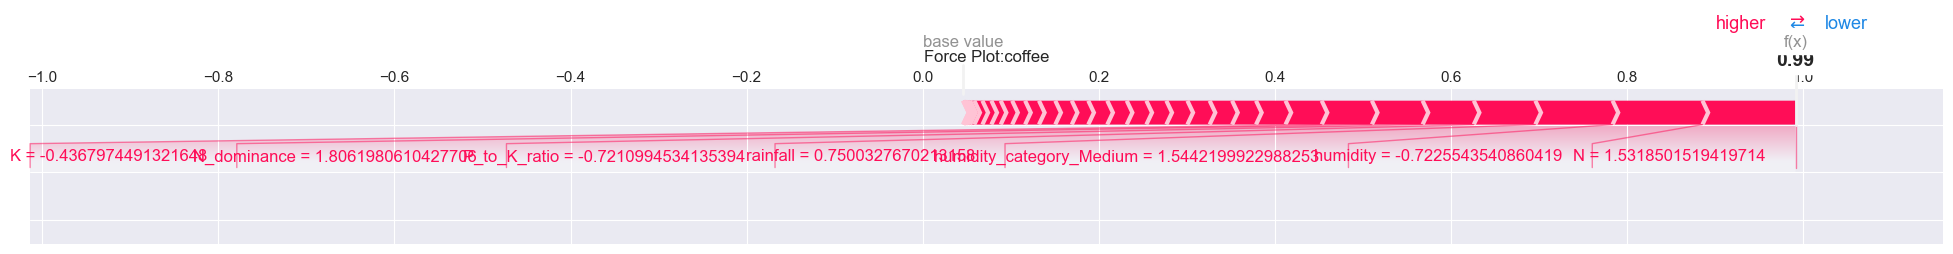

Saved: 53_shap_force_plot.png


In [ ]:
shap.force_plot(explainer.expected_value[predicted_class], shap_values[predicted_class][sample_idx],
                X_sample[sample_idx], feature_names=feature_names, matplotlib=True, show=False)
plt.title(f'Force Plot:{crop_names[predicted_class]}', fontsize=12)

plt.tight_layout()
plt.savefig('../data/visualizations/53_shap_force_plot.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: 53_shap_force_plot.png")

Interactive HTML

In [63]:
html_plot = shap.force_plot(explainer.expected_value[predicted_class], shap_values[predicted_class][sample_idx],
                            X_sample[sample_idx], feature_names=feature_names)
shap.save_html('../data/visualizations/53_shap_force_interactive.html', html_plot)
print("Saved: 53_shap_force_interactive.html")

Saved: 53_shap_force_interactive.html


# 8. Dependence Plots

In [64]:
key_features = ['N', 'P', 'K', 'rainfall', 'temperature', 'humidity', 'ph']
feature_indices = {f: feature_names.index(f) for f in key_features if f in feature_names}
print(f"Key features: {list(feature_indices.keys())}")

Key features: ['N', 'P', 'K', 'rainfall', 'temperature', 'humidity', 'ph']


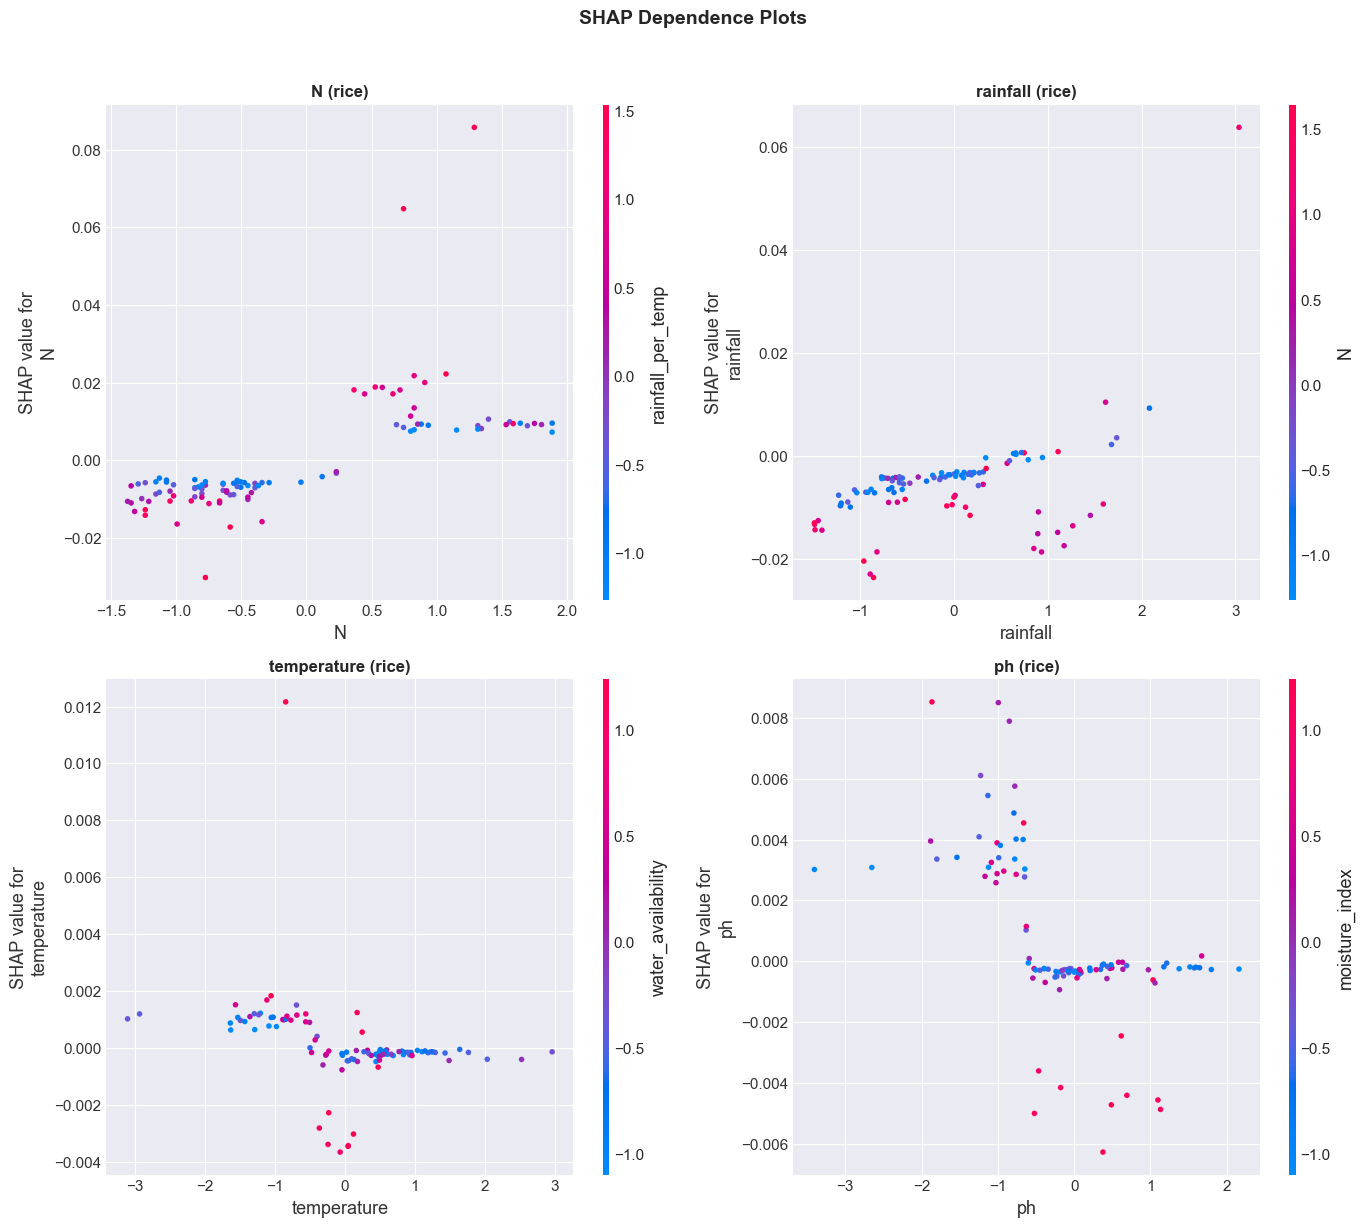

Saved: 54_shap_dependence.png


In [66]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
plot_features = ['N', 'rainfall', 'temperature', 'ph']

for ax, feat in zip(axes.flat, plot_features):
    if feat in feature_indices:
        shap.dependence_plot(feature_indices[feat], shap_values[crop_idx], X_sample,
                             feature_names=feature_names, ax=ax, show=False)
        ax.set_title(f'{feat} ({crop_names[crop_idx]})', fontsize=12, fontweight='bold')

plt.suptitle('SHAP Dependence Plots', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../data/visualizations/54_shap_dependence.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: 54_shap_dependence.png")

# 9. Crop-Feature Heatmap

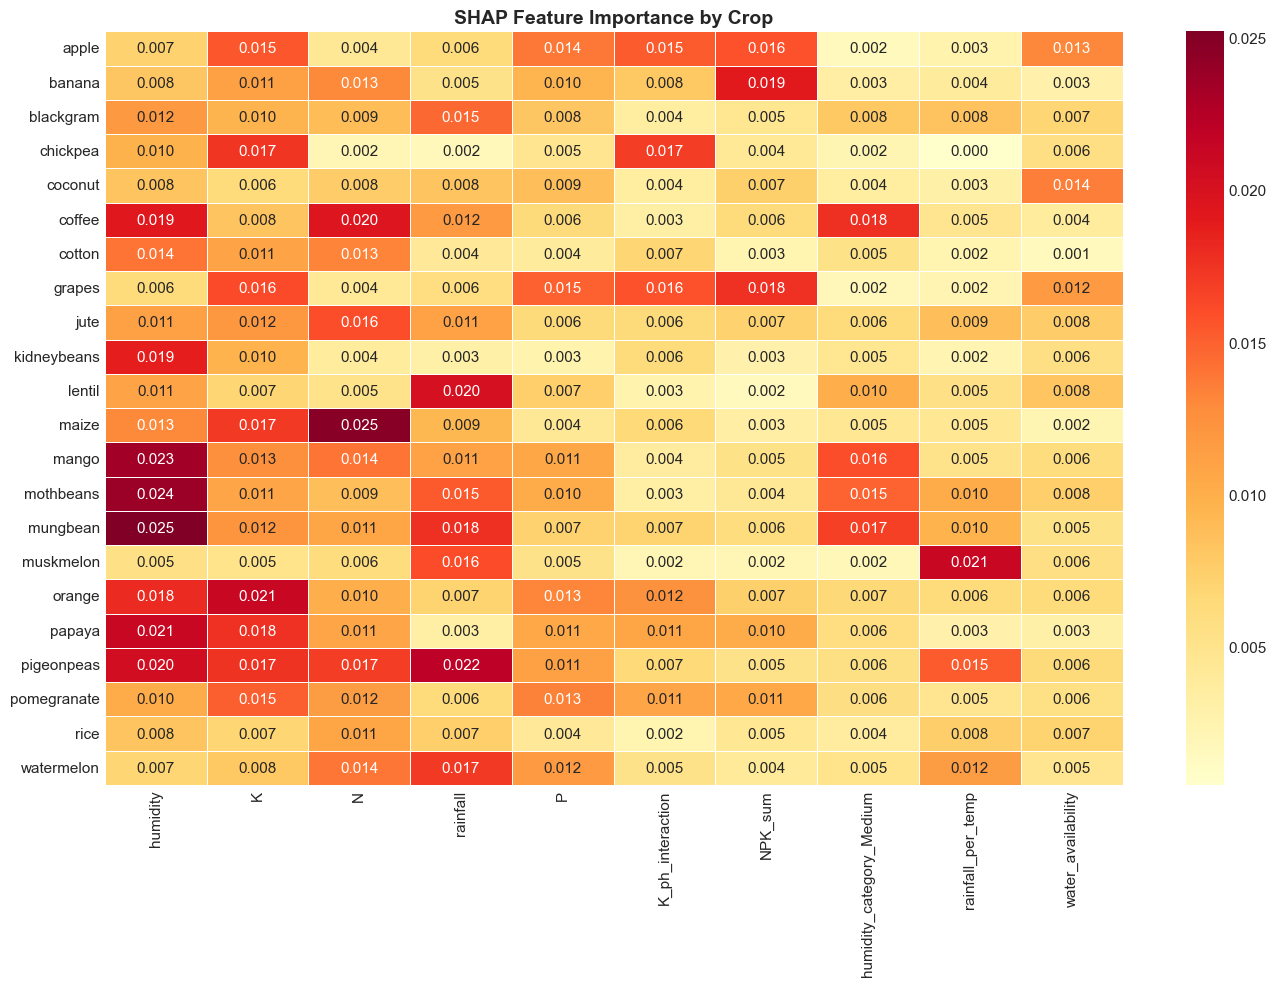

Saved: 55_shap_heatmap.png


In [68]:
top_features_list = feature_importance_df.head(10)['Feature'].tolist()

heatmap_data = []
for c_idx in range(n_classes):
    mean_shap = np.mean(np.abs(shap_values[c_idx]), axis=0)
    row = [mean_shap[feature_names.index(f)] for f in top_features_list]
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data, index=crop_names, columns=top_features_list)

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='YlOrRd', linewidths=0.5)
plt.title('SHAP Feature Importance by Crop', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../data/visualizations/55_shap_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: 55_shap_heatmap.png")

# 10. Explanation Templates

In [69]:
templates = []
for c_idx, crop in enumerate(crop_names):
    mean_shap = np.mean(shap_values[c_idx], axis=0)
    top_idx = np.argsort(np.abs(mean_shap))[-3:][::-1]
    factors = [f"{feature_names[i]} ({'higher' if mean_shap[i] > 0 else 'lower'})" for i in top_idx]
    templates.append({'crop': crop, 'factor_1': factors[0], 'factor_2': factors[1], 'factor_3': factors[2]})

templates_df = pd.DataFrame(templates)
print(templates_df.head(10).to_string(index=False))

       crop                   factor_1                   factor_2                   factor_3
      apple           NPK_sum (higher)                 K (higher)  K_ph_interaction (higher)
     banana       NPK_product (higher) rainfall_per_temp (higher)            NPK_sum (lower)
  blackgram water_stress_index (lower)                 K (higher)          humidity (higher)
   chickpea   K_ph_interaction (lower)                  P (lower)                  K (lower)
    coconut water_availability (lower)     moisture_index (lower)           rainfall (lower)
     coffee       N_to_K_ratio (lower)      P_to_K_ratio (higher)           NPK_sum (higher)
     cotton                  N (lower)   N_ph_interaction (lower)       N_to_K_ratio (lower)
     grapes          humidity (higher)        K_dominance (lower) water_availability (lower)
       jute          rainfall (higher)                 N (higher)      N_to_K_ratio (higher)
kidneybeans                 K (higher)      climate_index (lower)     

# 11. Save Results

In [71]:
os.makedirs('../models/explainers', exist_ok=True)

with open('../models/explainers/shap_explainer.pkl', 'wb') as f:
    pickle.dump(explainer, f)
print("shap_explainer.pkl")

np.save('../models/explainers/shap_values.npy', shap_stacked)
print("shap_values.npy")

np.save('../models/explainers/shap_sample_indices.npy', sample_indices)
print("shap_sample_indices.npy")

feature_importance_df.to_csv('../data/results/shap_feature_importance.csv', index=False)
print("shap_feature_importance.csv")

heatmap_df.to_csv('../data/results/shap_crop_feature_matrix.csv')
print("shap_crop_feature_matrix.csv")

templates_df.to_csv('../data/results/crop_explanation_templates.csv', index=False)
print("crop_explanation_templates.csv")

shap_explainer.pkl
shap_values.npy
shap_sample_indices.npy
shap_feature_importance.csv
shap_crop_feature_matrix.csv
crop_explanation_templates.csv
